In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pylab as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
import os
os.path.abspath('USvideos.csv')
path = r"/home/jovyan/DATA1030/DATA1030-Project/data/USvideos.csv"

**Load Data set**

In [3]:
df = pd.read_csv(path)

**Adding Columns to Data**

In [4]:
print("Data Frame shape: ", df.shape)
# print(df.nunique())
print(df.dtypes)
# change catagory_id to catagory name
df['category_name'] = np.nan

df.loc[(df["category_id"] == 1),"category_name"] = 'Film and Animation'
df.loc[(df["category_id"] == 2),"category_name"] = 'Cars and Vehicles'
df.loc[(df["category_id"] == 10),"category_name"] = 'Music'
df.loc[(df["category_id"] == 15),"category_name"] = 'Pets and Animals'
df.loc[(df["category_id"] == 17),"category_name"] = 'Sport'
df.loc[(df["category_id"] == 19),"category_name"] = 'Travel and Events'
df.loc[(df["category_id"] == 20),"category_name"] = 'Gaming'
df.loc[(df["category_id"] == 22),"category_name"] = 'People and Blogs'
df.loc[(df["category_id"] == 23),"category_name"] = 'Comedy'
df.loc[(df["category_id"] == 24),"category_name"] = 'Entertainment'
df.loc[(df["category_id"] == 25),"category_name"] = 'News and Politics'
df.loc[(df["category_id"] == 26),"category_name"] = 'How to and Style'
df.loc[(df["category_id"] == 27),"category_name"] = 'Education'
df.loc[(df["category_id"] == 28),"category_name"] = 'Science and Technology'
df.loc[(df["category_id"] == 29),"category_name"] = 'Non Profits and Activism'
df.loc[(df["category_id"] == 43),"category_name"] = 'Shows'

Data Frame shape:  (40949, 16)
video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object


**Check missing values**

In [ ]:
print(df.isnull().sum(axis=0)/df.shape[0])
print(sum(df.isnull().sum(axis=1)!=0)/df.shape[0])

In [5]:
# add more data based on current data set
df['like_rate'] =  df['likes'] / df['views'] * 100
df['dislike_rate'] =  df['dislikes']/df['views'] * 100
df['comment_log'] =  np.log10(df['comment_count'])
df['view_log'] = np.log10(df['views'])
df['interaction_rate'] = (df['likes'] + df['dislikes'] + 2 * df['comment_count'])/df['views'] * 100

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df[['video_id','title', 'category_name','interaction_rate']].groupby('video_id').agg('max').sort_values(ascending = False, by = 'interaction_rate')
group_by_object = df.groupby('video_id').count().sort_values('trending_date', ascending = 'True').reset_index()
intermediate = group_by_object[['video_id','trending_date']]
intermediate.columns = ['video_id', 'total_trending_days']
df = pd.merge(df, intermediate, on='video_id', how='left')
df = df.groupby('video_id').agg('max', column= 'views')
# df.columns
# print(df.shape)
# print(df.dtypes)

In [ ]:
# print(df.isnull().sum(axis=0)/df.shape[0])
# print(sum(df.isnull().sum(axis=1)!=0)/df.shape[0])

In [ ]:
# df[['title','views','category_name']].sort_values(by='views', ascending=False)[:10]

In [ ]:
# df[['title','views','category_name', 'interaction_rate']].sort_values(by='interaction_rate', ascending=False)[:10]

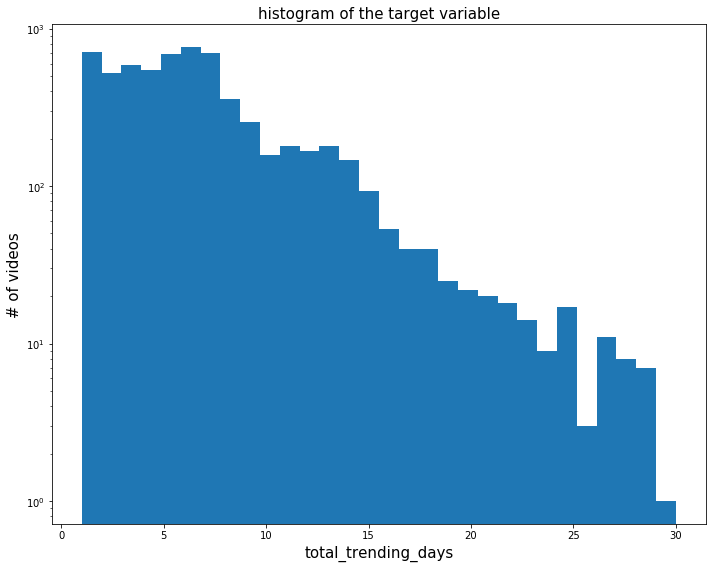

In [8]:
# histogram
plt.figure(figsize=(10,8))

# draw on the figure, define the properties of the line or marker
# plt.hist(y,bins=30,log=True)
df['total_trending_days'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('total_trending_days', fontsize = 15)
plt.ylabel('# of videos', fontsize = 15)
plt.title('histogram of the target variable', fontsize = 15)
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/y_hist.png',dpi=300)
plt.show()
# os.path.abspath('y_hist.png')

In [ ]:
# which categories are easier to be trending videos

print(df['category_name'].value_counts()/df['category_name'].shape)
plt.figure(figsize=(12,8))
p = sns.countplot(data=df, x = 'category_name')
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 18)
plt.ylabel('Video counts', fontsize=18)
plt.title("Video counts by Category Names", fontsize=20)
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/category_count.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
plt.figure(figsize = (14,9))
plt.subplot(211)
f2 = sns.boxplot(x='category_name', y='views', data=df)
f2.set_xticklabels(f2.get_xticklabels(),rotation=45)
f2.set_title("Views Distribuition by Category Names", fontsize=20)
f2.set_xlabel("", fontsize=15)
f2.set_ylabel("Views", fontsize=15)

plt.subplot(212)
f = sns.boxplot(x='category_name', y='view_log', data=df)
f.set_xticklabels(f.get_xticklabels(),rotation=90, fontsize = 16)
f.set_title("Log(views) Distribuition by Category Names", fontsize=20)
f.set_xlabel("", fontsize=15)
f.set_ylabel("log(views)", fontsize=15)

plt.subplots_adjust(hspace = 0.9, top = 0.9)
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/view_category.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
# correlation matrix
plt.figure(figsize=(10,10))
# plt.matshow(df.corr(),vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.matshow(df.corr(),vmin=-1,vmax=1,cmap=plt.cm.RdBu,fignum=0)

plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(df.corr().shape[0]),list(df.corr().columns),rotation=90, fontsize = 13)
plt.yticks(np.arange(df.corr().shape[0]),list(df.corr().columns),fontsize = 13)
plt.tight_layout()
plt.title('Correlation Matrix', y=-0.2, fontsize=20)
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/corr_coeff.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
# preprocess feature types one by one
# start machine learning 
num_ftrs = ['views', 'likes', 'dislikes', 'view_log','like_rate', 'dislike_rate', 'interaction_rate']
cat_ftrs = ['category_id', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed']

# one-hot encoder
ohe = OneHotEncoder(sparse=False)
si = SimpleImputer(strategy='constant',fill_value='missing')
cat_values = ohe.fit_transform(si.fit_transform(df[cat_ftrs]))
cat_ftr_names = ohe.get_feature_names()
df_cat = pd.DataFrame(data=cat_values,columns = cat_ftr_names)
# print(df_cat)

# standard scaler
ss = StandardScaler()
num_values = ss.fit_transform(df[num_ftrs])
df_num = pd.DataFrame(data=num_values,columns = num_ftrs)

df_preprocessed = pd.concat([df_cat,df_num],axis=1)
X = df_preprocessed
y = df['total_trending_days']
# df_preprocessed['total_trending_days'] = y
export_csv = df_preprocessed.to_csv (r'/home/jovyan/DATA1030/DATA1030-Project/data/preprocessed.csv', index = None, header=True) 
# print(df_preprocessed.shape)
# print(df_preprocessed.dtypes)

In [ ]:
# # correlation matrix
# plt.figure(figsize=(10,10))
# # plt.matshow(df.corr(),vmin=-1,vmax=1,cmap='seismic',fignum=0)
# plt.matshow(df_preprocessed.corr(),vmin=-1,vmax=1,cmap=plt.cm.RdBu,fignum=0)

# plt.colorbar(label='corr. coeff.')
# plt.xticks(np.arange(df_preprocessed.corr().shape[0]),list(df_preprocessed.corr().columns),rotation=90, fontsize = 13)
# plt.yticks(np.arange(df_preprocessed.corr().shape[0]),list(df_preprocessed.corr().columns),fontsize = 13)
# plt.tight_layout()
# plt.title('Correlation Matrix', y=-0.2, fontsize=20)
# plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/corr_coeff.png',dpi=300, bbox_inches = 'tight')
# plt.show()

In [ ]:
print(y.describe())
ftr_names = X.columns
X_np = X.values
y_np = y.values
# print(X_np.shape)
ftr_names

**Model 1: Lasso**

In [ ]:
def ML_pipeline_kfold_Lasso(X,y,random_state,n_folds):
    # split the data
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state = random_state)
    
    best_alphas = []
    test_scores = []
    # k folds - each fold will give us a CV and a test score
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # loop through 5 selected folders
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]
        
        # tune lasso hyper-parameter, alpha
#         alpha = np.logspace(-5,-1,num=8)
        alpha = [0.00005, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
        mse = []
        regs = []
        for a in alpha:
            reg = Lasso(alpha = a,max_iter = 1e4)
            reg.fit(X_train,y_train)
            mse.append(mean_squared_error(y_CV,reg.predict(X_CV)))
            regs.append(reg)
        # find the best alpha
        best_alphas.append(alpha[np.argmin(mse)])
        # grab the best model
        reg = regs[np.argmin(mse)]
        test_scores.append(reg.score(X_test, y_test))
    best_a = best_alphas[np.argmax(test_scores)]
    return best_a, min(mse), max(test_scores), reg

test_scores_lasso = []
regs_lasso = []
mses_lasso = []
for i in range(10):
    best_a, best_mse, test_score, reg = ML_pipeline_kfold_Lasso(X_np,y_np,42*i,5)
    test_scores_lasso.append(test_score)
    regs_lasso.append(reg)
    mses_lasso.append(best_mse)
    print('Best alpha is {}. MSE is {}. Best score is {}'.format(best_a, best_mse, 
                                                                 max(test_scores_lasso)))
print('MSE:',np.around(np.mean(mses_lasso),2),'+/-',
      np.around(np.std(mses_lasso),2))
print('Lasso test scores:',np.around(np.mean(test_scores_lasso),2),'+/-',
      np.around(np.std(test_scores_lasso),2))

**Model 2: random forest**

In [ ]:
def ML_pipeline_kfold_rf(X,y,random_state,n_folds):
    # split the data
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state = random_state)
    test_scores = []
#     best_pairs = []
    # k folds - each fold will give us a CV and a test score
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # loop through 5 selected folders
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]
        
        # tune random forest hyper-parameter, depth and min sample split
        depths = [i for i in range(1,15)]
        sss = [i for i in range(5,15)]
#         train_score = defaultdict(lambda: 0)
        mse = defaultdict(lambda: 0)
        regs = defaultdict(lambda: RandomForestRegressor(n_estimators=10, max_depth=2, min_samples_split=2, random_state=random_state))
        for i,depth in enumerate(depths):
            for j,ss in enumerate(sss):
                reg = RandomForestRegressor(n_estimators=10, max_depth=depth, min_samples_split=ss, random_state=random_state)
                reg.fit(X_train, y_train)
#                 train_score[(i,j)] = mean_squared_error(y_train, reg.predict(X_train))
                mse[(i,j)] = mean_squared_error(y_CV, reg.predict(X_CV))
                regs[(i,j)] = reg
        # find the best alpha in this fold
        best_pair = min(mse, key=mse.get)
#         best_pairs.append(best_pair)
        best_depths = depths[best_pair[0]]
        best_sss = sss[best_pair[1]]
        # grab the best model
        reg = regs[best_pair]
#         CV_scores.append(np.min(CV_score))
        # calculate test score using thee best model
        test_scores.append(reg.score(X_test, y_test))
    return best_depths, best_sss, max(test_scores), min(mse.values()), reg

regs_rf = []
test_scores_rf = []
mses_rf = []
for i in range(10):
    best_depths, best_sss, test_score, mse, reg = ML_pipeline_kfold_rf(X_np,y_np,42*i,5)
#     CV_scores.append(CV_score)
    test_scores_rf.append(test_score)
    regs_rf.append(reg)
    mses_rf.append(mse)
    print('Best depth is {}. Best sample split is {}. MSE is {}. Best score is {}'.format(
        best_depths, best_sss, mse, max(test_scores_rf)))
print('MSE:',np.around(np.mean(mses_rf),2),'+/-',
      np.around(np.std(mses_rf),2))
print('Random Forest test MSE:',np.around(np.mean(test_scores_rf),2),'+/-',np.around(np.std(test_scores_rf),2))

In [ ]:
globalp = regs_rf[np.argmax(test_scores_rf)]
print(globalp)
globalp.feature_importances_

In [ ]:
d = {'ftr_imp': globalp.feature_importances_}
pd.DataFrame(d, index=ftr_names).plot.bar(legend=None, figsize=(20, 15))
plt.ylabel('feature importance')
plt.title('Feature importance in the Random Forest Model', fontsize=20)
# plt.title('Feature importance in the Random Forest Model', y=-0.2, fontsize=20)
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/feature_impo.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def ML_pipeline_xgb(X,y,random_state,n_folds):
    
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
#    X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=random_state)
    CV_scores = []
    test_scores = []
    
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)

    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index], X_other.iloc[CV_index]
        y_train, y_CV = y_other.iloc[train_index], y_other.iloc[CV_index]
    
        data = []
        r2 = []
        max_depth = [1,3,5,7,9]
        sub_sample = [0.5, 0.6, 0.8, 1.0]
        gamma = [0, 1, 5, 7]

        for i in max_depth:
            for j in sub_sample:
                for g in gamma:
                    
                    XGB = xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.15, max_depth = i, 
                                               n_estimators = 100, subsample=j, gamma = g)
                    XGB.fit(X_train,y_train,early_stopping_rounds=50,eval_set=[(X_CV, y_CV)], verbose=False)
                    y_CV_pred = XGB.predict(X_CV)

                    data.append([i, j, g, XGB, r2_score(y_CV, y_CV_pred)])

        df3 = pd.DataFrame(data, columns = ['max_depth', 'sub_sample', 'gamma', 'model', 'cv_scores_xgb'])
        cv_best = max(df3['cv_scores_xgb'])
        index = np.argmax(np.array(df3['cv_scores_xgb']))
        pair_best = (df3['max_depth'][index],df3['sub_sample'][index],df3['gamma'][index])
        xgb = df3['model'][index]
        y_test_pred = xgb.predict(X_test)
        CV_scores.append(cv_best)
        r2.append(r2_score(y_test, y_test_pred))

    return CV_scores, r2, pair_best


test_scores_xgb = []
CV_scores_xgb = []
for i in range(1,4):
    CV_score, r2, pair_best = ML_pipeline_xgb(X,y,42*i,3)
    test_scores_xgb += r2
    CV_scores_xgb.append(CV_score)
    print("The best max_depth and sub sample and gamma on the {}th round: {}".format(i, pair_best))
    print("The MSE is", CV_score, "and the R2 score is", r2)
    
print('MSE:',np.around(np.mean(CV_scores_xgb),2), '+/-', np.around(np.std(CV_scores_xgb),2))
print('test accuracy:',np.around(np.mean(test_scores_xgb),2), '+/-', np.around(np.std(test_scores_xgb),2))

In [ ]:
# # Train an SVR
# def ML_pipeline_kfold_svr(X,y,random_state,n_folds):
#     X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
#                                                         random_state = random_state)
#     CV_scores = []
#     test_scores = []
#     kf = KFold(n_splits=n_folds, shuffle=True,random_state=random_state)
#     for train_index, CV_index in kf.split(X_other,y_other):
#         X_train, X_CV = X_other[train_index], X_other[CV_index]
#         y_train, y_CV = y_other[train_index], y_other[CV_index]

#         # tune svr hyper-parameter, gamma and c 
#         gammas= np.logspace(-9, 3, 13)
#         Cs = np.logspace(1, 10, 10)
# #         train_score = defaultdict(lambda: 0)
#         CV_score = defaultdict(lambda: 0)
#         regs = defaultdict(lambda: SVR(gamma = 1, C = 1, probability=True, random_state=random_state))
#         for i,gamma_value in enumerate(gammas):
#             for j,c in enumerate(Cs):
#                 reg = SVR(gamma = gamma_value, C = c)
#                 reg.fit(X_train, y_train)
# #                 train_score[(i,j)] = accuracy_score(y_train, reg.predict(X_train))
#                 CV_score[(i,j)] = mean_squared_error(y_CV, reg.predict(X_CV))
#                 regs[(i,j)] = reg
#         # find the best alpha in this fold
#         best_CV_pair = min(CV_score, key=CV_score.get)
#         best_gamma = gammas[best_CV_pair[0]]
#         best_c = Cs[best_CV_pair[1]]
#         # grab the best model
#         reg = regs[best_CV_pair]
#         CV_scores.append(np.min(CV_score))
#         # calculate test score using thee best model
#         test_scores.append(reg.score(X_test, y_test))
    
# #     print("best gamma is ", best_gamma)
# #     print("best c is ", best_c)

#     return best_gamma, best_c, min(CV_scores.values()), test_scores

# test_scores_svr = []
# for i in range(10):
#     best_gamma, best_c, CV_scores, test_scores = ML_pipeline_kfold_svr(X,y,42*i,2)
#     test_scores_svr.append(test_scores)
#     print('Best gamma is {}. Best c is {}. MSE is {}. Best score is {}'.format(
#         best_gamma, best_c, CV_scores, max(test_scores_svr)))
# print("SVR best accuracy is ",np.around(np.mean(test_scores_svr),2), '+/-', np.around(np.std(test_scores_svr),2))